In [6]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imports for time series analysis
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm

# imports for time series forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster

# call ARIMA (includes sarima/sarimax) model
from statsmodels.tsa.arima.model import ARIMA

## another SARIMAX implementation from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

# box-cox transformation for skeewed data
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# data transformation functions

# find best boxcox transformation. Include datetime index if given
def boxcox_transform(x,lmda=None,alpha=None,optimizer=None):
    if type(x) == pd.core.frame.DataFrame:
        index = x.index
        name = x.name
        if lmda == None:
            boxcox_data, lmda = boxcox(x, lmbda=None, alpha=None, optimizer=None)

            boxcox_data = pd.DataFrame(boxcox_data, index=index, columns=[name])
            return boxcox_data, lmda
        else:
            boxcox_data = boxcox(x, lmbda=lmda, alpha=None, optimizer=None)

            boxcox_data = pd.DataFrame(boxcox_data, index=index, columns=[name])

            return boxcox_data
    elif type(x) == pd.core.series.Series:
        index = x.index
        name = x.name
        if lmda == None:
            boxcox_data, lmda = boxcox(x, lmbda=None, alpha=None, optimizer=None)

            boxcox_data = pd.Series(data=boxcox_data, index=index, name=name)
            
            return boxcox_data, lmda
        else:
            boxcox_data = boxcox(x, lmbda=lmda, alpha=None, optimizer=None)

            boxcox_data = pd.DataFrame(boxcox_data, index=index, columns=[name])

            return boxcox_data
    else:
        if lmda == None:
            boxcox_data, lmda = boxcox(x, lmbda=None, alpha=None, optimizer=None)
            return boxcox_data, lmda
        else:
            boxcox_data = boxcox(x, lmbda=lmda, alpha=None, optimizer=None)
            return boxcox_data

# reverse transformation. Include datetime index if given
def inv_boxcox_tranform(x, lmda, out=None):

    reversed_data = inv_boxcox(x, lmda, out=None)

    if type(x) == pd.core.frame.DataFrame:
        index = x.index
        name = x.name

        reversed_data = pd.DataFrame(reversed_data, index=index, columns=[name])

        return reversed_data

    elif type(x) == pd.core.series.Series:
        index = x.index
        name = x.name
        
        return reversed_data
        
    else:
        return reversed_data


import warnings
warnings.filterwarnings("ignore")

# load inflow dataset into dataframe
#inflow_data = pd.read_excel("../InflowData_1.xlsx")
inflow_data = pd.read_csv("../data/inflow_imputed.csv")

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
#inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")
inflow_data.index = pd.to_datetime(inflow_data.index)

# make list with dma names
dma_list = list(inflow_data.columns.values)

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# # print first two rows
# inflow_data.head(3)

In [7]:
# weather data
weather_data = pd.read_csv("../data/weather_imputed.csv")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index)

# make list of special days for the DMAs region
official_holidays = ["2021-01-01","2021-01-06","2021-04-04","2021-04-05","2021-04-25","2021-05-01","2021-06-02","2021-08-15","2021-11-01","2021-12-05","2021-12-25","2021-12-26","2022-01-01","2022-01-06","2022-04-17","2022-04-18","2022-04-25","2022-05-01","2022-06-22","2022-08-15","2022-11-01","2022-12-08","2022-12-25","2022-12-26"]

legally_not_recongnized_holidays = ["2021-04-23","2021-05-23","2022-04-23","2022-06-05"]

event_day = ["2021-03-28","2021-05-09","2021-10-31","2021-11-28","2021-05-12","2021-12-12","2021-12-19","2021-12-31","2022-03-27","2022-04-10","2022-05-08","2022-05-09","2022-10-30","2022-11-27","2022-12-04","2022-12-11","2022-12-18","2022-12-31"]

# make columns for special days
weather_data['official_holiday'] = 0
weather_data['legally_not_recongnized_holidays'] = 0
weather_data['event_day'] = 0
weather_data['weekend'] = 0

# add indicator variable for speciall days
for i in weather_data.index:
    if str(i)[:10] in official_holidays:
        weather_data['official_holiday'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in legally_not_recongnized_holidays:
        weather_data['legally_not_recongnized_holidays'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in event_day:
        weather_data['event_day'][i] = 0

# add variable for weekend days
for i in weather_data.index:
    if i.weekday() == 5 or i.weekday() == 6:
        weather_data['weekend'][i] = 1

# drop uncorrelated features
#weather_data = weather_data.drop(['Rainfall depth (mm)','Air humidity (%)','Windspeed (km/h)'], axis=1)

In [8]:
# create an utility metric function
def print_metrics(y_obs,y_pred, model_name,return_df=None):
    MeanAE_24h = 1/24 * np.sum(np.abs(y_obs[0:24] - y_pred[0:24]))

    MaxAE_24h = np.max(np.abs(y_obs[0:24] - y_pred[0:24]))

    MeanAE_144h = 1/144 * np.sum(np.abs(y_obs[24:168] - y_pred[24:168]))

    total_sum = np.sum(MeanAE_24h + MaxAE_24h + MeanAE_144h)

    dict_ = {'MeanAE-24h': MeanAE_24h, 'MaxAE-24h': MaxAE_24h,
             'MeanAE-144h': MeanAE_144h, 'Total': total_sum}
    
    df = pd.DataFrame(dict_, index = [model_name])
    
    print(model_name)
    print(f"MeanAE-24h      MaxAE-24h      MeanAE-144h      Total")
    print(f"{MeanAE_24h:.2f}            {MaxAE_24h:.2f}             {MeanAE_144h:.2f}           {total_sum:.2f} \n")
    if return_df == 1:
        return(df.round(decimals = 3))

In [9]:
# define start and end dates for analysis (last week is used for evaluation)
start = '2021-07-19'
end = '2022-07-24'

# make feature time series dataframe
tseriesX_df = weather_data.copy()

# reduce time series to specified start and end dates
tseriesX_df = tseriesX_df[start:end].copy()

# make train and test sets
X = tseriesX_df
X_train, X_test = temporal_train_test_split(X, test_size=168)

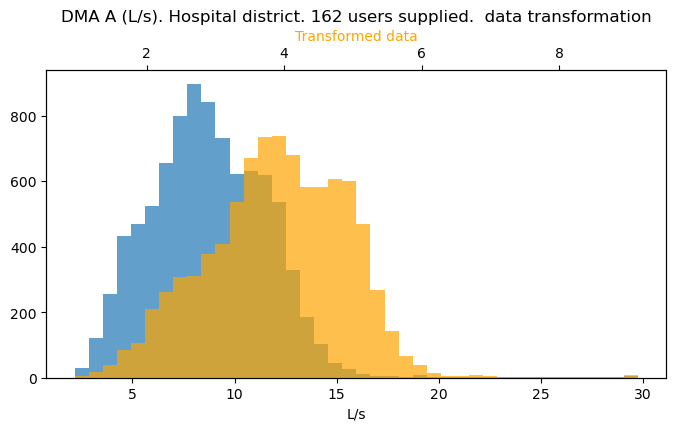

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.18850D-01    |proj g|=  6.58788D-01

At iterate    5    f=  7.34233D-01    |proj g|=  2.91975D-01

At iterate   10    f=  7.22363D-01    |proj g|=  6.15884D-01

At iterate   15    f=  6.70534D-01    |proj g|=  1.25466D-01

At iterate   20    f=  6.59518D-01    |proj g|=  4.98080D-02

At iterate   25    f=  6.57402D-01    |proj g|=  9.20079D-02

At iterate   30    f=  6.55232D-01    |proj g|=  8.98548D-02

At iterate   35    f=  6.49285D-01    |proj g|=  1.49098D-01

At iterate   40    f=  6.45681D-01    |proj g|=  8.63320D-02

At iterate   45    f=  6.42708D-01    |proj g|=  1.46109D-01

At iterate   50    f=  6.41663D-01    |proj g|=  1.81722D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

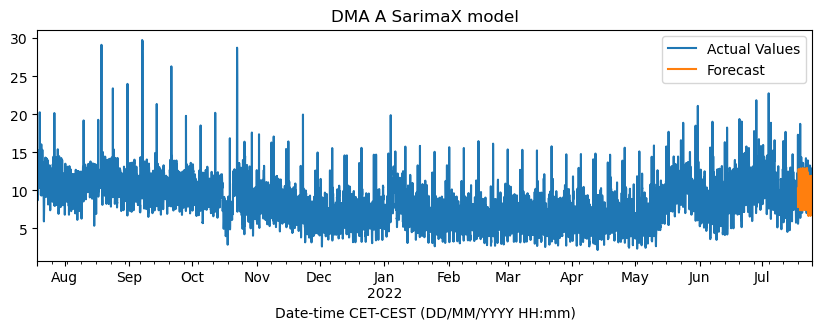

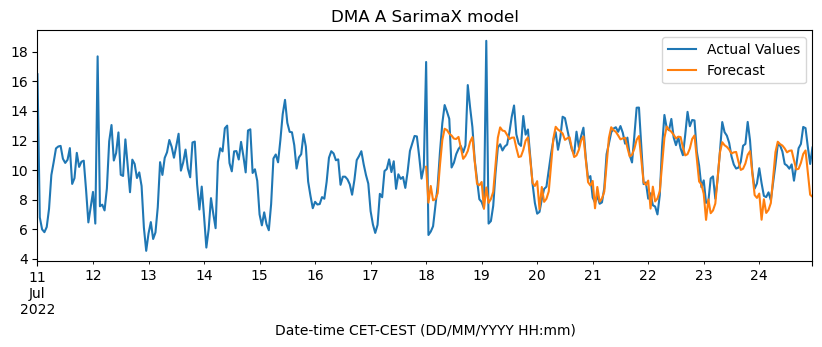

Performance indicators
DMA A SarimaX-Box-Cox 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.53            7.08             0.92           9.52 

Performance indicators


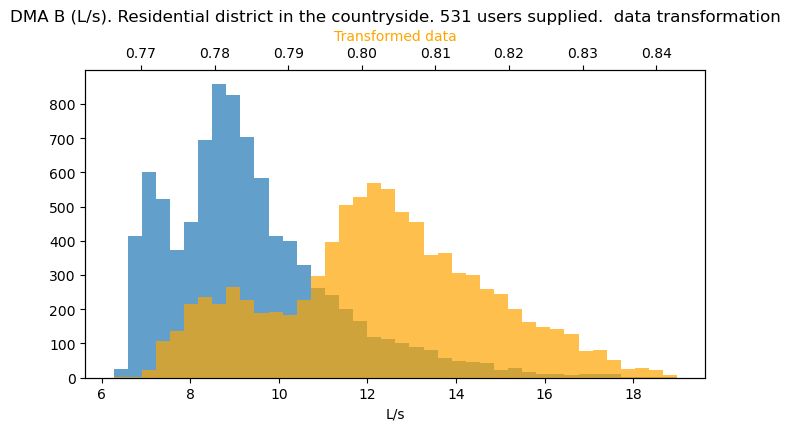

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.11582D+00    |proj g|=  1.30651D+01

At iterate    5    f= -4.11582D+00    |proj g|=  4.94270D+00

At iterate   10    f= -4.11582D+00    |proj g|=  2.23165D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     11     61      1     0     0   2.232D+00  -4.116D+00
  F =  -4.1158228376128685     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


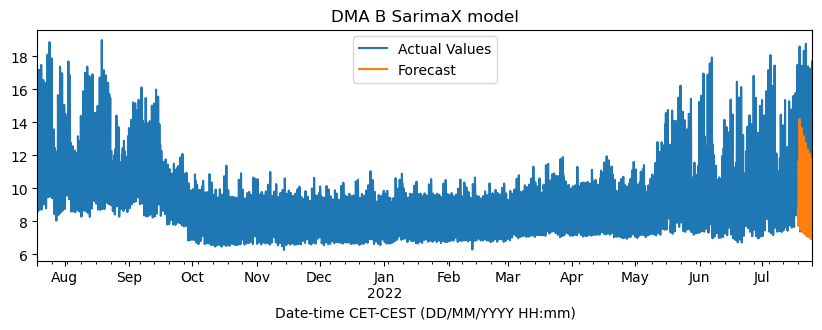

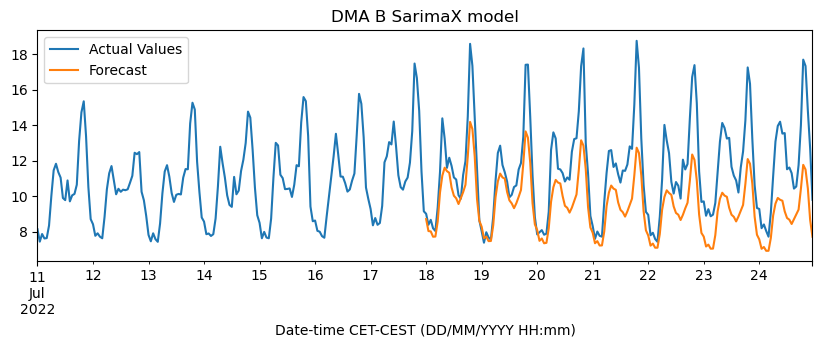

Performance indicators
DMA B SarimaX-Box-Cox 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.26            4.40             2.13           7.80 

Performance indicators


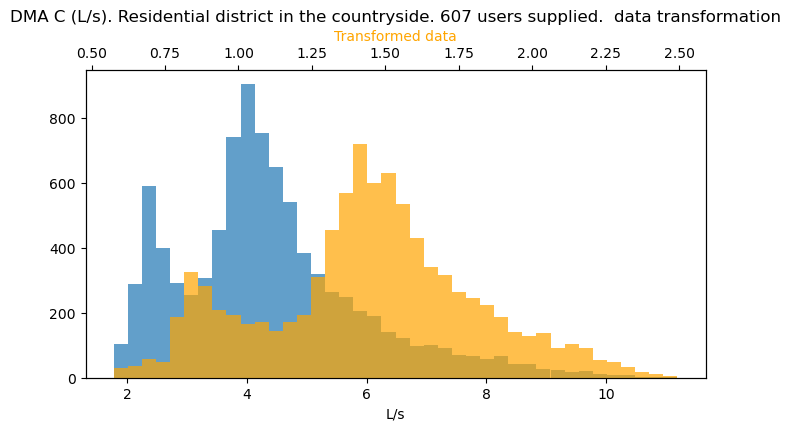

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.07857D+00    |proj g|=  2.86805D+00


 This problem is unconstrained.



At iterate    5    f= -1.10114D+00    |proj g|=  1.20333D-01

At iterate   10    f= -1.10348D+00    |proj g|=  1.39179D+00

At iterate   15    f= -1.11020D+00    |proj g|=  4.25319D-01

At iterate   20    f= -1.11567D+00    |proj g|=  2.01038D+00

At iterate   25    f= -1.13515D+00    |proj g|=  1.36048D+00

At iterate   30    f= -1.13616D+00    |proj g|=  1.11679D-01

At iterate   35    f= -1.13744D+00    |proj g|=  1.83126D+00

At iterate   40    f= -1.13946D+00    |proj g|=  1.02077D+00

At iterate   45    f= -1.14435D+00    |proj g|=  4.77373D-01

At iterate   50    f= -1.14748D+00    |proj g|=  2.08044D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

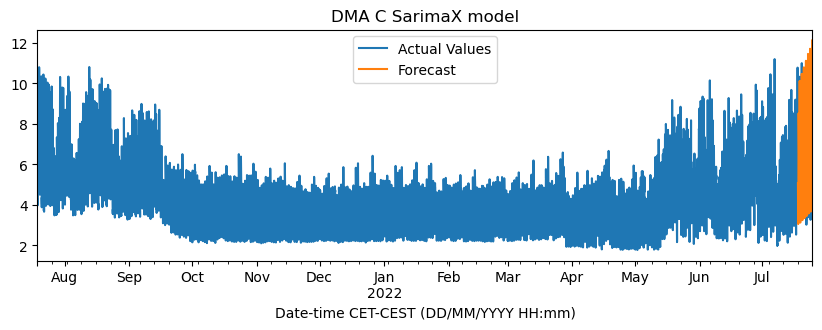

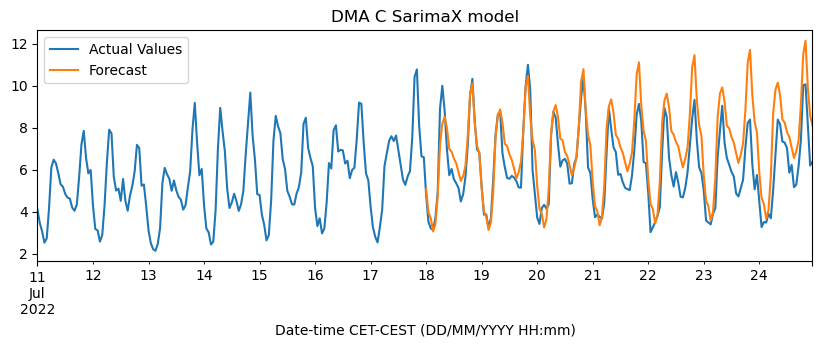

Performance indicators
DMA C SarimaX-Box-Cox 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.62            1.80             1.17           3.58 

Performance indicators
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43100D+00    |proj g|=  1.12233D-01


 This problem is unconstrained.



At iterate    5    f=  2.36053D+00    |proj g|=  1.02109D-01

At iterate   10    f=  2.33775D+00    |proj g|=  5.39008D-02

At iterate   15    f=  2.31936D+00    |proj g|=  1.35601D-02

At iterate   20    f=  2.31792D+00    |proj g|=  1.65389D-02

At iterate   25    f=  2.31776D+00    |proj g|=  1.00868D-02

At iterate   30    f=  2.31765D+00    |proj g|=  1.56804D-02

At iterate   35    f=  2.31733D+00    |proj g|=  2.22736D-02

At iterate   40    f=  2.31585D+00    |proj g|=  2.89502D-02

At iterate   45    f=  2.31479D+00    |proj g|=  8.48560D-03

At iterate   50    f=  2.31302D+00    |proj g|=  2.04157D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

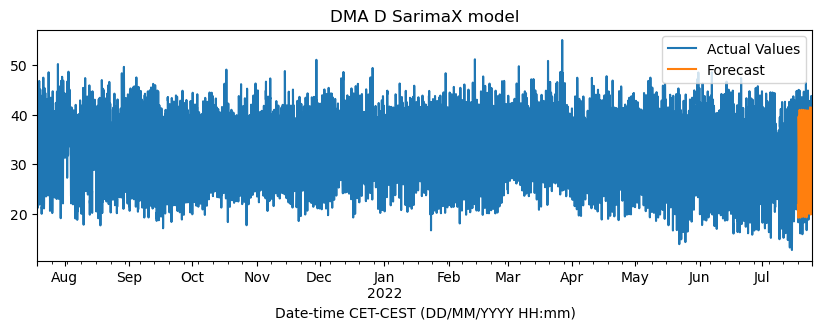

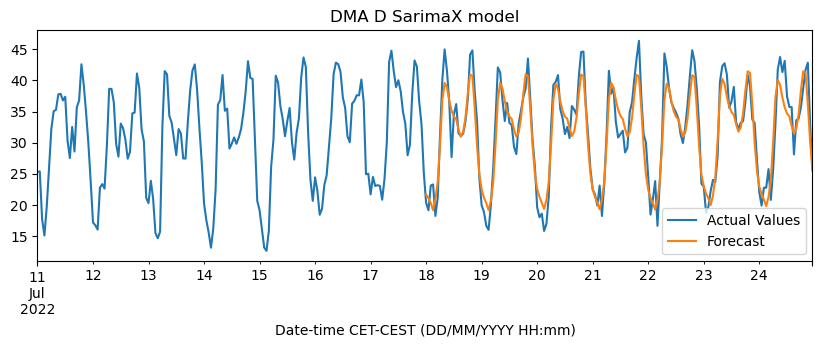

Performance indicators
DMA D SarimaX-Box-Cox 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.33            7.46             2.29           12.08 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54138D+00    |proj g|=  9.70175D-02


 This problem is unconstrained.



At iterate    5    f=  2.46835D+00    |proj g|=  2.98271D-01

At iterate   10    f=  2.42991D+00    |proj g|=  8.45575D-02

At iterate   15    f=  2.42034D+00    |proj g|=  3.27687D-02

At iterate   20    f=  2.41814D+00    |proj g|=  6.41658D-03

At iterate   25    f=  2.41753D+00    |proj g|=  1.04072D-02

At iterate   30    f=  2.41612D+00    |proj g|=  6.28640D-03

At iterate   35    f=  2.41525D+00    |proj g|=  2.59936D-02

At iterate   40    f=  2.41465D+00    |proj g|=  7.66669D-03

At iterate   45    f=  2.41461D+00    |proj g|=  4.80753D-03

At iterate   50    f=  2.41452D+00    |proj g|=  5.54757D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

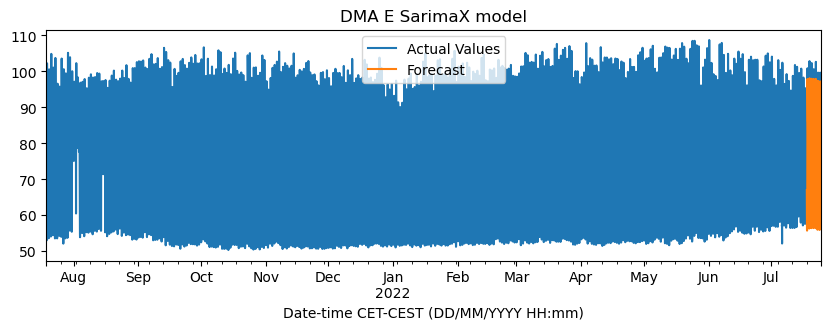

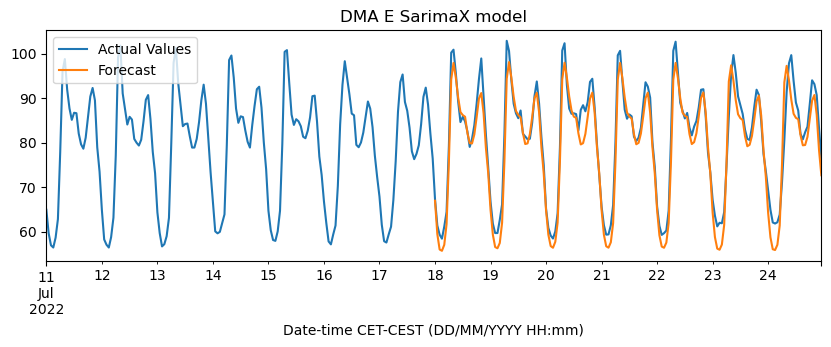

Performance indicators
DMA E SarimaX-Box-Cox 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.54            7.77             2.83           13.15 



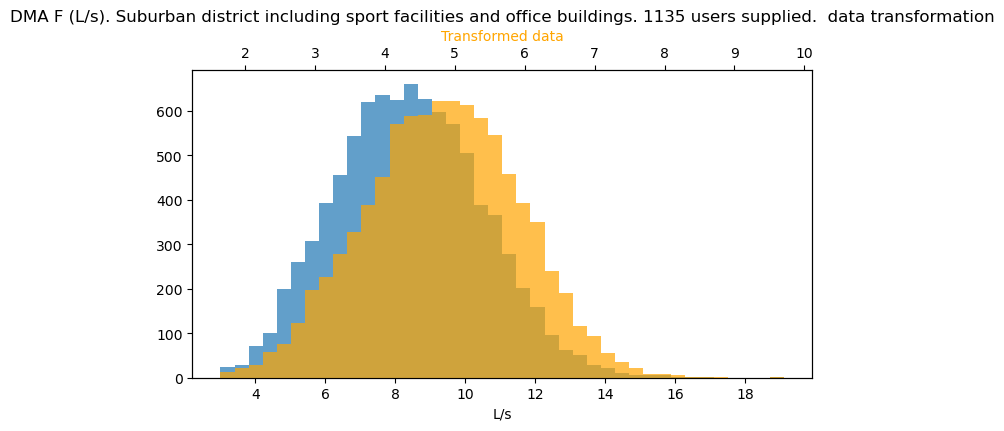

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.61471D-01    |proj g|=  5.84923D-01


 This problem is unconstrained.



At iterate    5    f=  7.98461D-01    |proj g|=  1.18296D-01

At iterate   10    f=  7.81507D-01    |proj g|=  5.01369D-01

At iterate   15    f=  7.67774D-01    |proj g|=  1.12153D+00

At iterate   20    f=  7.51830D-01    |proj g|=  9.24321D-01

At iterate   25    f=  7.48436D-01    |proj g|=  2.01200D-01

At iterate   30    f=  7.44860D-01    |proj g|=  8.93947D-02

At iterate   35    f=  7.39121D-01    |proj g|=  1.33166D-01

At iterate   40    f=  7.38039D-01    |proj g|=  9.93687D-02

At iterate   45    f=  7.35880D-01    |proj g|=  1.19817D-01

At iterate   50    f=  7.35681D-01    |proj g|=  4.75916D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

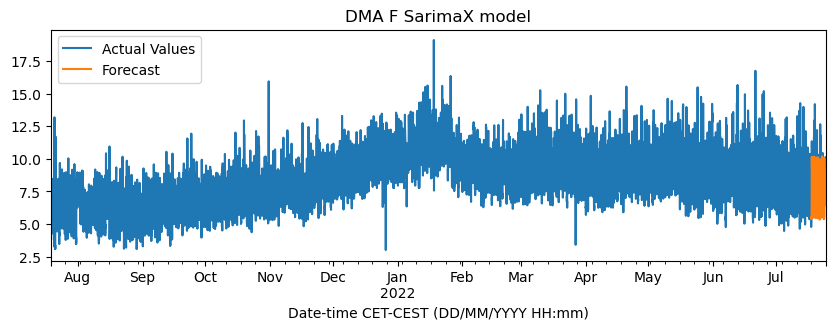

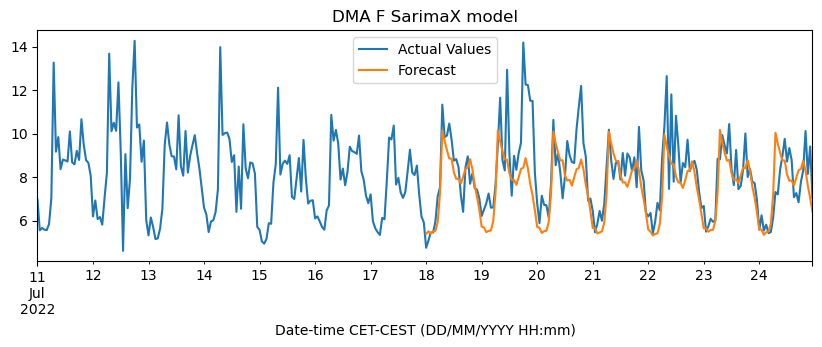

Performance indicators
DMA F SarimaX-Box-Cox 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.61            1.61             1.02           3.23 

Performance indicators


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87418D+00    |proj g|=  1.25894D-01

At iterate    5    f=  1.81821D+00    |proj g|=  1.19346D-01

At iterate   10    f=  1.76013D+00    |proj g|=  1.17819D-01

At iterate   15    f=  1.75069D+00    |proj g|=  8.21042D-03

At iterate   20    f=  1.75041D+00    |proj g|=  5.86940D-03

At iterate   25    f=  1.75015D+00    |proj g|=  8.16741D-03

At iterate   30    f=  1.74995D+00    |proj g|=  9.23165D-03

At iterate   35    f=  1.74966D+00    |proj g|=  5.26377D-03

At iterate   40    f=  1.74960D+00    |proj g|=  2.30922D-03

At iterate   45    f=  1.74956D+00    |proj g|=  5.92398D-03

At iterate   50    f=  1.74913D+00    |proj g|=  3.25317D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

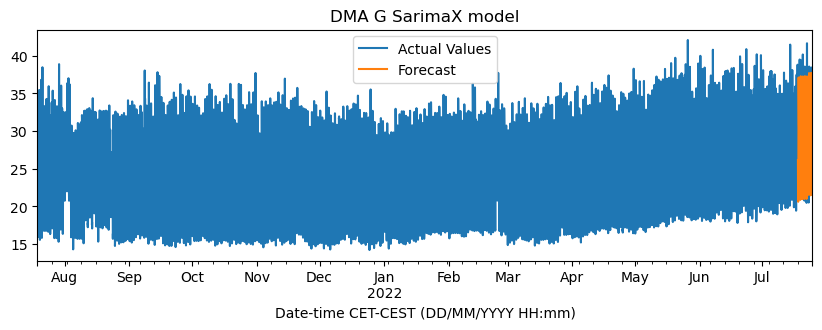

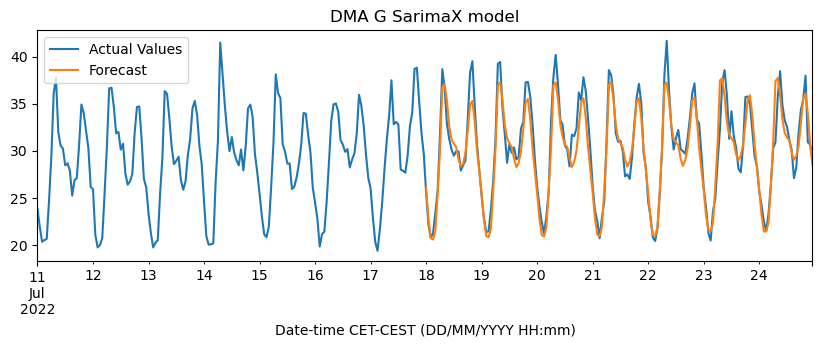

Performance indicators
DMA G SarimaX-Box-Cox 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.19            4.20             1.24           6.63 



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59444D+00    |proj g|=  1.56411D-01

At iterate    5    f=  1.55677D+00    |proj g|=  1.16213D-01

At iterate   10    f=  1.49532D+00    |proj g|=  1.86771D-01

At iterate   15    f=  1.48785D+00    |proj g|=  2.51398D-02

At iterate   20    f=  1.48663D+00    |proj g|=  5.69740D-02

At iterate   25    f=  1.48419D+00    |proj g|=  2.81611D-02

At iterate   30    f=  1.47998D+00    |proj g|=  2.05070D-02

At iterate   35    f=  1.47903D+00    |proj g|=  6.01532D-03

At iterate   40    f=  1.47879D+00    |proj g|=  5.94706D-03

At iterate   45    f=  1.47847D+00    |proj g|=  9.79254D-03

At iterate   50    f=  1.47836D+00    |proj g|=  2.60434D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

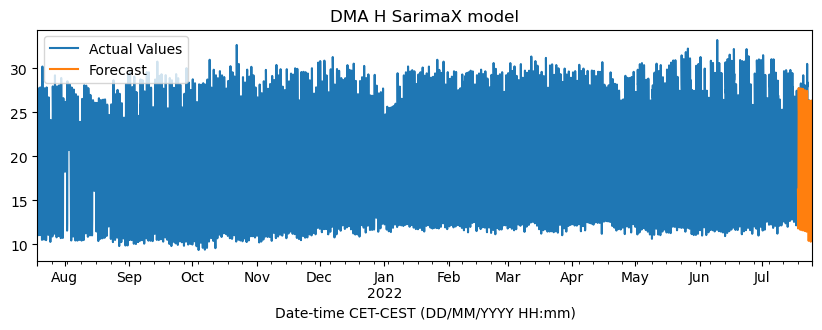

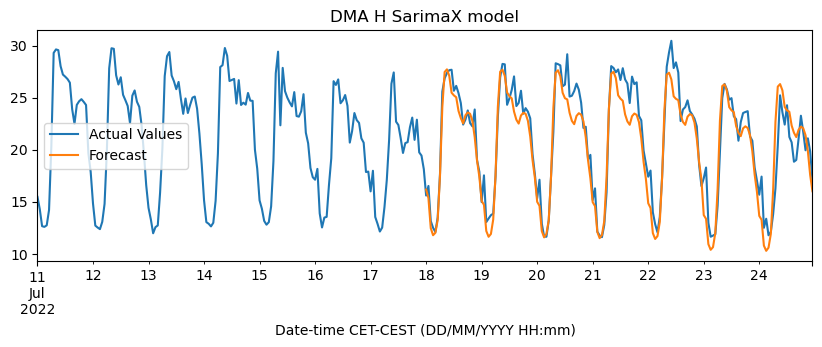

Performance indicators
DMA H SarimaX-Box-Cox 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.79            2.66             1.47           4.92 



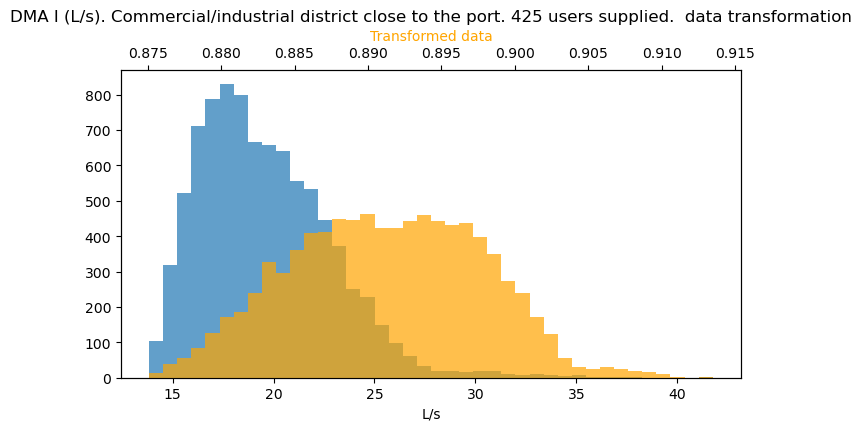

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.42308D+00    |proj g|=  1.13358D+02

At iterate    5    f= -4.47688D+00    |proj g|=  3.82963D+00

At iterate   10    f= -4.47701D+00    |proj g|=  1.69358D+01

At iterate   15    f= -4.47770D+00    |proj g|=  1.69530D+01

At iterate   20    f= -4.47803D+00    |proj g|=  8.24160D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     21     45      1     0     0   8.242D+00  -4.478D+00
  F =  -4.4780324382758669     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


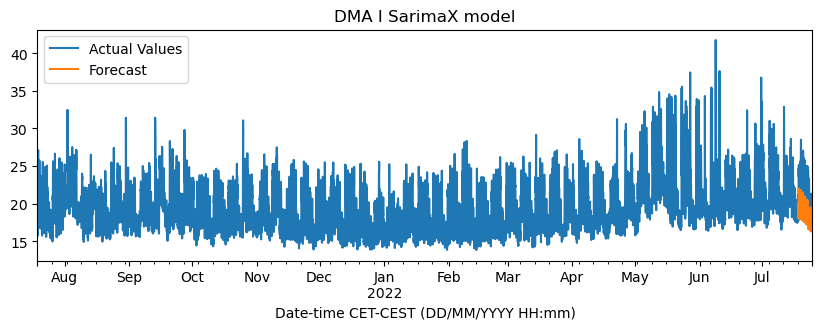

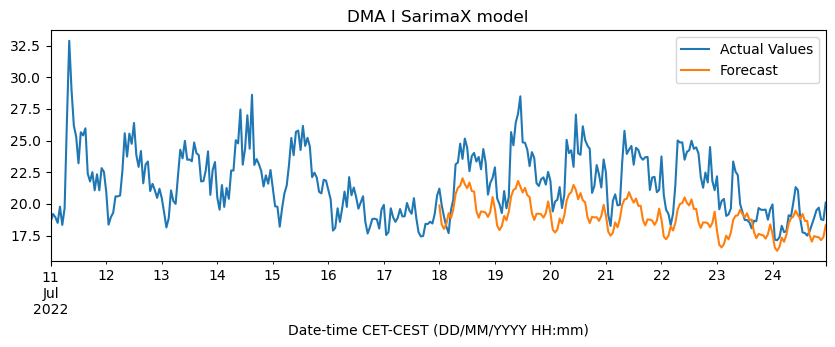

Performance indicators
DMA I SarimaX-Box-Cox 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.34            4.94             2.75           10.03 

Performance indicators


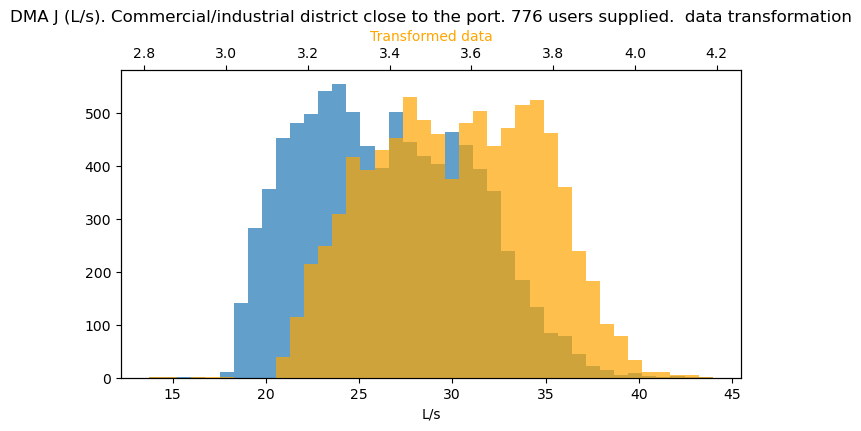

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23466D+00    |proj g|=  4.26942D+00

At iterate    5    f= -1.27759D+00    |proj g|=  1.01813D-01

At iterate   10    f= -1.27826D+00    |proj g|=  1.72491D+00

At iterate   15    f= -1.28200D+00    |proj g|=  2.02339D+00

At iterate   20    f= -1.28321D+00    |proj g|=  1.36132D+00

At iterate   25    f= -1.28386D+00    |proj g|=  2.27800D-01

At iterate   30    f= -1.28512D+00    |proj g|=  1.84032D+00

At iterate   35    f= -1.29208D+00    |proj g|=  2.59976D+00

At iterate   40    f= -1.29751D+00    |proj g|=  1.35246D+00

At iterate   45    f= -1.29898D+00    |proj g|=  1.28540D-01

At iterate   50    f= -1.30086D+00    |proj g|=  3.73113D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

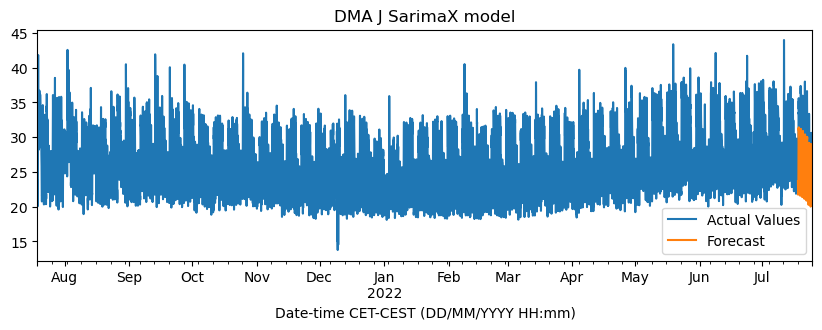

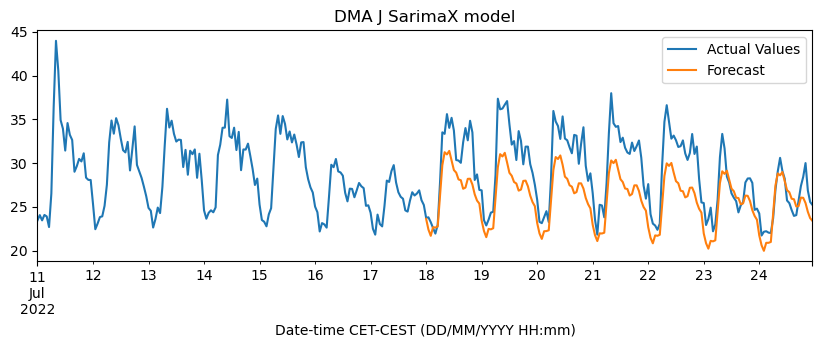

Performance indicators
DMA J SarimaX-Box-Cox 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.87            6.80             3.13           12.80 

Performance indicators


In [10]:
# make empty datafram to store results
results_df = pd.DataFrame()

# make dictionary with dma position in description list
dict_dma = dict(zip(dma_list, np.arange(0,len(dma_list))))

i = 0
# select dma for analysis
for dma in list(inflow_data.columns):
    
    # copy data from dataframe in a new time series dataframe
    tseries_df = inflow_data[dma][start:end].copy()

    ## data transformation
    if dma not in ['DMA D (L/s)','DMA E (L/s)','DMA G (L/s)','DMA H (L/s)']:
        inflow_data_transformed, lmda = boxcox_transform(tseries_df,lmda=None,alpha=None,optimizer=None)

        # compare distributions of original and transformed data
        fig, ax = plt.subplots(figsize=(8,4))
        ax2 = ax.twiny()
        plt.title(dma + ". " + dma_descripton[i] +". "+ str(users_supplied[i]) + " users supplied. " + " data transformation")
        ax.hist(tseries_df.values, density=False,bins=40,alpha=0.7)
        ax2.hist(inflow_data_transformed.values, density=False,bins=40, color='orange', alpha=0.7)
        plt.ylabel('Counts')
        ax.set_xlabel("L/s")
        ax2.set_xlabel("Transformed data", color='orange')
        plt.show()


        # demand time series
        y = inflow_data_transformed
        y_train, y_test = temporal_train_test_split(y, test_size = 168)

        y_train_original, y_test_original = temporal_train_test_split(tseries_df, test_size = 168)

        # exogenous variables time series
        X = tseriesX_df
        X_train, X_test = temporal_train_test_split(X, test_size=168)

        # implement sarimaX model    
        # the statsmodel package applies the difference already if needed.

        model = SARIMAX(y_train, exog=X_train, order=(4,1,3), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
        model_fit = model.fit()
        # print(model_fit.summary())

        # make predictions
        y_pred = model_fit.get_forecast(len(y_test), exog=X_test).summary_frame(alpha=0.05)

        # recover prediction in original format
        y_pred_recovered = inv_boxcox_tranform(y_pred['mean'], lmda, out=None)
        y_pred_recovered_lower = inv_boxcox_tranform(y_pred['mean_ci_lower'], lmda, out=None)
        y_pred_recovered_upper = inv_boxcox_tranform(y_pred['mean_ci_upper'], lmda, out=None)

        # plot results
        fig, ax = plt.subplots(figsize = (10,3))
        tseries_df.plot(title = dma[:5]+' SarimaX model', ax = ax)
        y_pred_recovered.plot(y='mean',ax = ax)
        #ax.fill_between(y_pred_recovered.index, y_pred_recovered_lower, y_pred_recovered_upper,color='orange', alpha=0.3)
        ax.legend(['Actual Values', 'Forecast'])
        plt.show()

        # plot forecast and last two weeks of time series
        fig, ax = plt.subplots(figsize = (10,3))
        tseries_df['2022-07-11':'2022-07-24'].plot(title = dma[:5]+' SarimaX model', ax = ax)
        y_pred_recovered.plot(y='mean',ax = ax)
        #ax.fill_between(y_pred_recovered.index, y_pred_recovered_lower, y_pred_recovered_upper,color='orange', alpha=0.3)
        ax.legend(['Actual Values', 'Forecast'])
        plt.show()

        print('Performance indicators')
        df = print_metrics(y_test_original, y_pred_recovered, dma[:5]+' SarimaX-Box-Cox 52-Weeks',return_df=1)
        results_df = pd.concat([results_df, df])
        print('Performance indicators')
    else:
        # demand time series
        y = tseries_df
        y_train, y_test = temporal_train_test_split(y, test_size = 168)

        # exogenous variables time series
        X = tseriesX_df
        X_train, X_test = temporal_train_test_split(X, test_size=168)

        # implement sarimaX model    
        # the statsmodel package applies the difference already if needed.
        model = SARIMAX(y_train, exog=X_train, order=(4,1,3), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
        model_fit = model.fit()
        # print(model_fit.summary())

        y_pred = model_fit.get_forecast(len(y_test), exog=X_test).summary_frame(alpha=0.05)


        fig, ax = plt.subplots(figsize = (10,3))
        tseries_df.plot(title = dma[:5]+' SarimaX model', ax = ax)
        y_pred.plot(y='mean',ax = ax)
        #ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
        ax.legend(['Actual Values', 'Forecast'])
        plt.show()

        # plot forecast and last two weeks of time series
        fig, ax = plt.subplots(figsize = (10,3))
        tseries_df['2022-07-11':'2022-07-24'].plot(title = dma[:5]+' SarimaX model', ax = ax)
        y_pred.plot(y='mean',ax = ax)
        ax.legend(['Actual Values', 'Forecast'])
        plt.show()

        print('Performance indicators')
        df = print_metrics(y_test, y_pred['mean'], dma[:5]+' SarimaX-Box-Cox 52-Weeks',return_df=1)
        results_df = pd.concat([results_df, df])
    i = i+1

In [11]:
results_df

,MeanAE-24h,MaxAE-24h,MeanAE-144h,Total
DMA A SarimaX-Box-Cox 52-Weeks,1.526,7.082,0.916,9.524
DMA B SarimaX-Box-Cox 52-Weeks,1.261,4.399,2.135,7.795
DMA C SarimaX-Box-Cox 52-Weeks,0.615,1.803,1.166,3.584
DMA D SarimaX-Box-Cox 52-Weeks,2.329,7.459,2.293,12.081
DMA E SarimaX-Box-Cox 52-Weeks,2.540,7.773,2.835,13.148
DMA F SarimaX-Box-Cox 52-Weeks,0.606,1.609,1.020,3.235
DMA G SarimaX-Box-Cox 52-Weeks,1.187,4.202,1.241,6.630
DMA H SarimaX-Box-Cox 52-Weeks,0.787,2.655,1.473,4.915
DMA I SarimaX-Box-Cox 52-Weeks,2.339,4.944,2.746,10.029
DMA J SarimaX-Box-Cox 52-Weeks,2.874,6.799,3.127,12.800


In [12]:
results_df['Total'].sum()

83.74099999999999